In [1]:
#To install the necessary packages, please run this cell:
!py -m pip install -r pip_requirements.txt



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Our analysis centers on the effect DVDs on the movie industry. This question was motivated by an interview with actor Matt Damon, famous for his role in [Good Will Hunting](https://www.imdb.com/title/tt0119217/?ref_=ext_shr_lnk) and [the Martian](https://www.imdb.com/title/tt3659388/?ref_=ext_shr_lnk). 

In the interview with the [New York Times](https://www.nytimes.com/2021/07/27/magazine/matt-damon.html) , he claims that with the fall of DVDs, production companies lost a sizeable portion of their revenue and must rely almost entirely on box office revenues. The consequence of this, he claims, is that movies are now simpler and more international, to ensure broad appeal and better revenues at the box office:

"You know, because the DVD market dried up [...] that severely cut into the margins that studios would rather bet big on these big titles. And with this whole international audience, the more, you know, the simpler the story the more that it can kind of play, the less language matters so that the more broad appeal that it can play around the world, and that’s why you’re seeing the movies change."

With this in mind, we will analyze the effect of DVDs on the movie industry by looking at the following aspects:
- [DVD releases over time](#DVD-releases-over-time)
- [General Overview](#General-Overview)
- [Revenue](#Revenue-overview) 
- [Budget](#Budget-overview)
- [Production company](#Production-companies)
- [Runtime](#Runtime-overview)   
- [Genre](#Genre-overview)
- [Themes](#Themes-extraction)


IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset [here](https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz)
and TMDB dataset [here (Download button)](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)

In [3]:
#!py src/scripts/clean_data.py

In [3]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')

# Budget overview
## Main plots
We export here the main plots to be used for the budget analysis

In [4]:
df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of budget for each DVD era:


dvd_era,pre,during,post
count,3.048000e+03,9.461000e+03,1.162500e+04
mean,1.099374e+07,1.416679e+07,8.876990e+06
std,1.488392e+07,2.873422e+07,2.925404e+07
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+05,2.000000e+05,3.000000e+03
50%,5.475000e+06,2.400000e+06,1.400000e+05
75%,1.500000e+07,1.400000e+07,3.500000e+06
max,1.750000e+08,3.790000e+08,8.880000e+08


We can see that most budget statistics (quantiles, median and mean) are lower in the post-DVD era, but the maximum budget is higher. 

We examine the budget trends in more details using plots. 

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


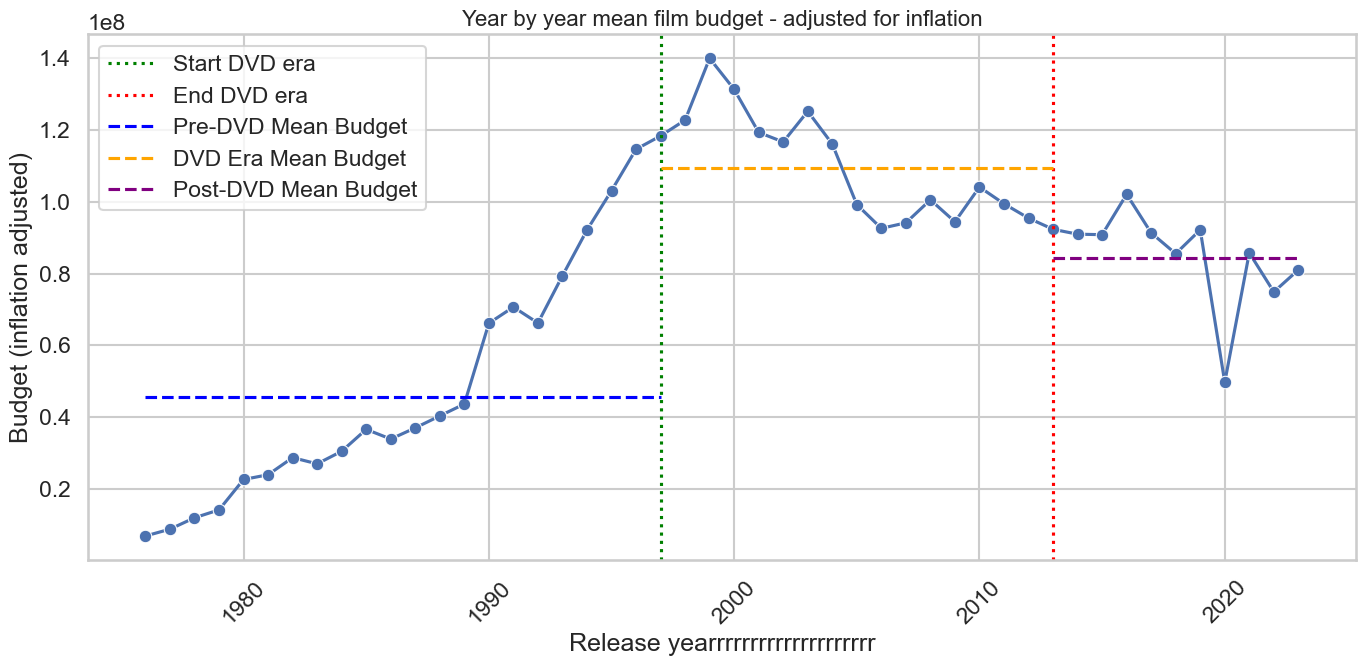

In [5]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

In [6]:
plot_movies_budget_slider(df_filtered, mode='budget')      # Budget mode (default)
plot_movies_budget_slider(df_filtered, mode='relative')    # Relative mode
plot_movies_budget_slider(df_filtered, mode='percentage')  # Percentage mode

## Statistical tests

In [8]:
from statsmodels.formula.api import ols

import statsmodels.api as sm

# Filter out rows with budget <= 0
df_filtered_budget = df[df['budget'] > 0]

# Linear regression model
X = sm.add_constant(df_filtered_budget['release_year'])
y = df_filtered_budget['budget']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 budget   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     77.76
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.24e-18
Time:                        19:10:30   Log-Likelihood:            -4.4783e+05
No. Observations:               24134   AIC:                         8.957e+05
Df Residuals:                   24132   BIC:                         8.957e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.048e+08   3.33e+07      9.155   

Really bad R squared shows that the regression is not satisfying. Given the general form of the plot, this is not a surprise.

In [9]:
# ANOVA test
anova_model = ols('budget ~ C(release_year)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                       sum_sq        df          F         PR(>F)
C(release_year)  3.802337e+16      47.0  13.761637  2.684742e-106
Residual         2.137720e+19  363637.0        NaN            NaN


Significance of release_year: The very low  p-value suggests that the release year has a significant effect on the dependent variable. In other words, the differences in means across the years are unlikely to be due to random chance.

F-statistic: The F-statistic of 13.72 supports this conclusion, showing that the between-group variance (due to release_year) is large relative to the within-group variance (residuals).

Residuals: While release_year is significant, the residual sum of squares is much larger than the explained sum of squares, suggesting that there is still a large amount of variability in the data that is unexplained by release_year.

In [10]:
from scipy.stats import chi2_contingency

# Create a contingency table for chi-square test
contingency_table = pd.crosstab(df_filtered['dvd_era'], df_filtered['budget'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square test statistic: 9184.06373236485
P-value: 3.9153454204873014e-105
Degrees of freedom: 6400


This indicates that there is extremely strong evidence against the null hypothesis (no association between budget and dvd era), and we can conclude that there is a statistically significant association between dvd_era and budget.

## Other plots

We can use histograms to compare film budgets before, during and after the DVD era. We use a log-scale to represent movies with both small and high budgets on the same graph. This leads to the results of pre vs. post DVD era to be unreadable. 


We can nevertheless interpret the results for adjacent eras :
- Pre vs. during: before DVDs, only high budgets films were produced, with a mono-modal distribution, around 10^7 dollars budget. During the DVD era, the distribution widened, with smaller budget films being produced.
- During vs. post: after the DVD era, we see the distribution becoming more bimodal with another density maximum around 10^4 dollars.

Interpreting this is tricky : maybe more movies can become available in streaming services, pushing for smaller-budget productions.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local

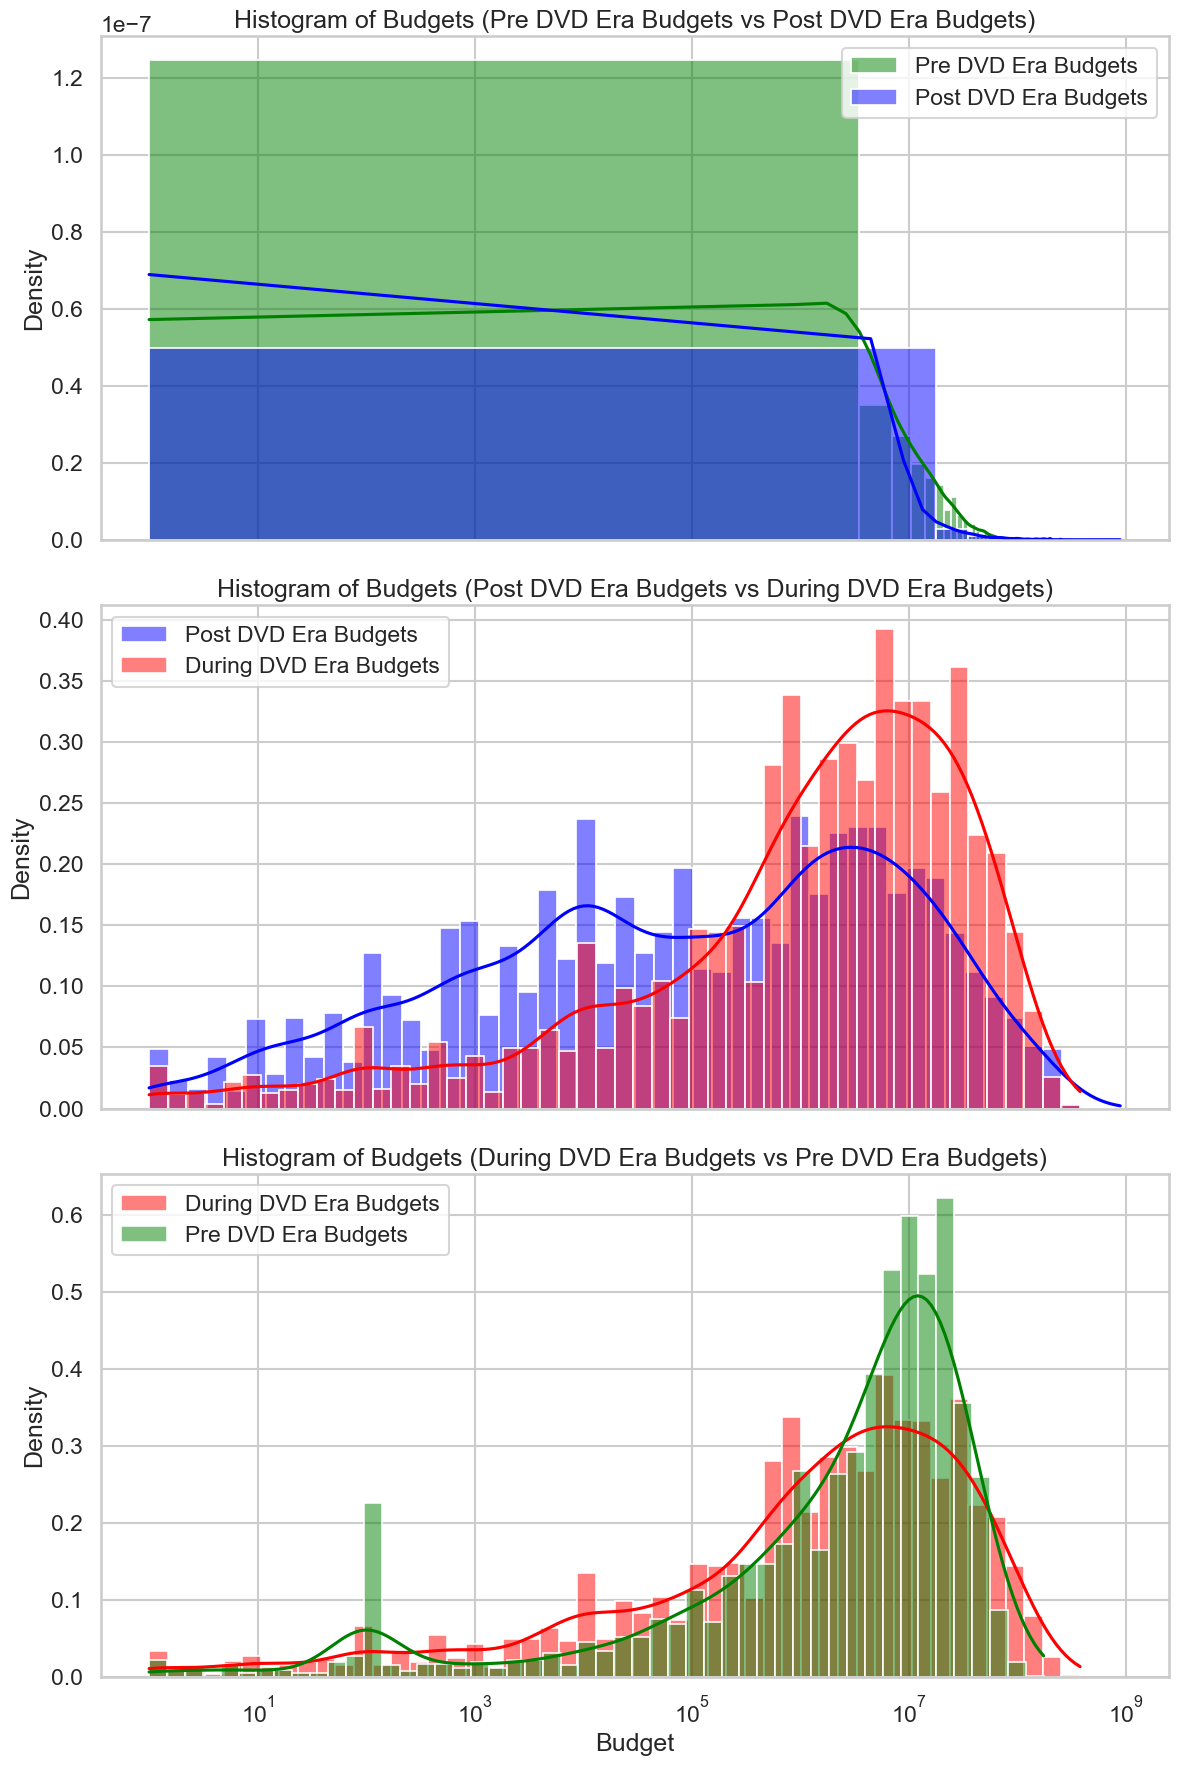

In [11]:

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

We categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

The most interesting finding is that the DVD era seems to correspond to a loss of interest for really expensive movies. This can be explained by the fact that :
- Before DVDs, going to the cinema was exceptional, but also the only way to consume movies. So only big franchises with high production budgets could really make a lot of profit.
- After DVDs, the streaming platforms want to differentiate from each other by giving access to exceptional movies, that are really costly.

In [12]:
df_filtered.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during
3,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during
4,deadpool,2016-02-09,783100000,108,58000000,en,the origin story of former special forces oper...,"[action, adventure, comedy]","[20th century fox, the donners' company, genre...",[united states of america],[english],"[superhero, anti hero, mercenary, based on com...",2016,post


c:\Users\nicol\OneDrive - CentraleSupelec\Bureau\Cours EPFL\ADA\Project\ada-2024-project-databand\src\utils\data_utils.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119:

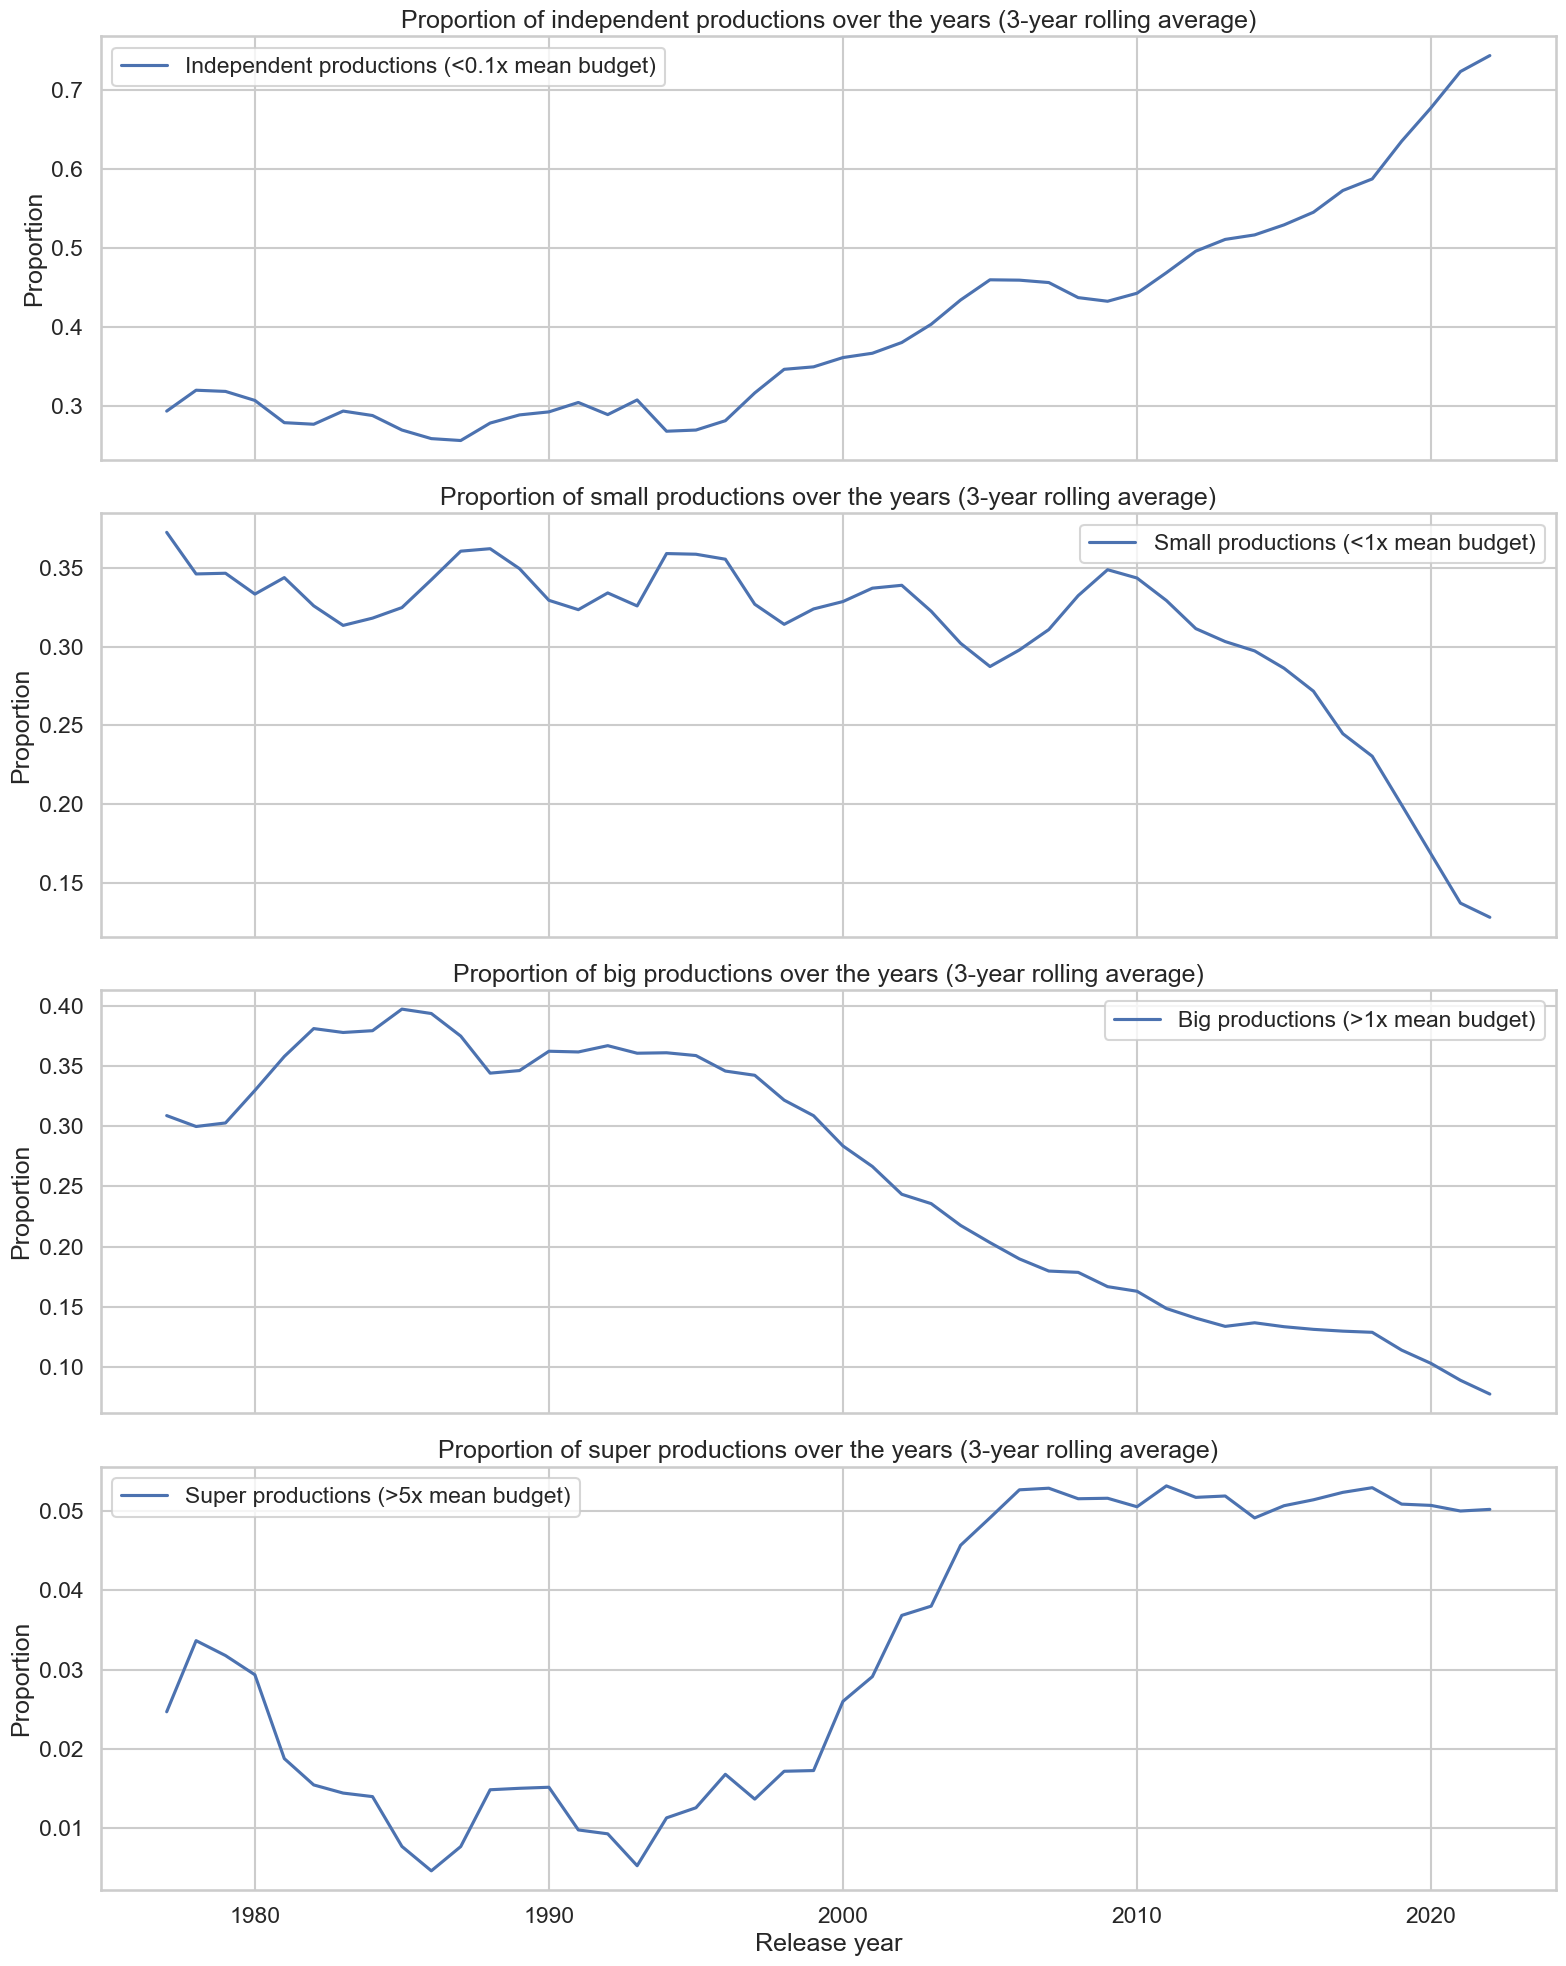

In [13]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)